In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Install & import libraries

In [ ]:
!pip install -q emoji
!pip install -q datasets
!pip install -q transformers
!pip install -q tf-models-official
!pip3 install vncorenlp

     |████████████████████████████████| 133kB 6.7MB/s 
     |████████████████████████████████| 245kB 5.3MB/s 
     |████████████████████████████████| 122kB 9.7MB/s 
     |████████████████████████████████| 245kB 9.5MB/s 
     |████████████████████████████████| 2.5MB 6.9MB/s 
     |████████████████████████████████| 901kB 30.3MB/s 
     |████████████████████████████████| 3.3MB 46.1MB/s 
     |████████████████████████████████| 1.6MB 6.8MB/s 
     |████████████████████████████████| 358kB 22.6MB/s 
     |████████████████████████████████| 102kB 8.1MB/s 
     |████████████████████████████████| 645kB 23.5MB/s 
     |████████████████████████████████| 1.2MB 38.4MB/s 
     |████████████████████████████████| 686kB 53.7MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 215kB 56.4MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 
     |████████████████████████████████| 2.7MB 6.8MB/s 
  Cre

In [ ]:
!pip install -q vncorenlp
!git clone https://github.com/vncorenlp/VnCoreNLP.git

Cloning into 'VnCoreNLP'...
remote: Enumerating objects: 212, done.
remote: Total 212 (delta 0), reused 0 (delta 0), pack-reused 212
Receiving objects: 100% (212/212), 214.21 MiB | 64.74 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [ ]:
import numpy as np
import tensorflow as tf
import torch
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from vncorenlp import VnCoreNLP

tf.get_logger().setLevel('ERROR')
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.72.161.94)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by CenturyLink (Omaha, NE) [12.44 km]: 26.27 ms
Testing download speed................................................................................
Download: 1096.84 Mbit/s
Testing upload speed......................................................................................................
Upload: 116.59 Mbit/s


In [ ]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/ViCTSD_toxic/BERT_base/images')
MODEL_PATH = os.path.join(path_root, 'model/ViCTSD_toxic/BERT_base')
name_model = 'ViCTSD_toxic_BERT_base'

path_ViCTSD_train_toxic = os.path.join(path_root, 'data/UIT-ViCTSD/UIT-ViCTSD_train.csv')
path_ViCTSD_test_toxic = os.path.join(path_root, 'data/UIT-ViCTSD/UIT-ViCTSD_test.csv')
path_ViCTSD_dev_toxic = os.path.join(path_root, 'data/UIT-ViCTSD/UIT-ViCTSD_valid.csv')

# Accelerator

## Connect to the TPU worker

In [ ]:
if os.environ['COLAB_TPU_ADDR']: 
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print('Using TPU')
    print("All devices: ", tf.config.list_logical_devices('TPU'))
elif tf.test.is_gpu_available():
    strategy = tf.distribute.MirroredStrategy()
    print('Using GPU')
else: raise ValueError('Running on CPU is not recommended.')

Using TPU
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Import datasets

In [ ]:
df_train = pd.read_csv(path_ViCTSD_train_toxic, encoding='utf-8').iloc[:, 1:]
df_test = pd.read_csv(path_ViCTSD_test_toxic, encoding='utf-8').iloc[:, 1:]
df_dev = pd.read_csv(path_ViCTSD_dev_toxic, encoding='utf-8').iloc[:, 1:]

In [ ]:
df_train = df_train.astype({"Constructiveness": "int", "Toxicity": "int", 'Comment': "string"})
df_dev = df_dev.astype({"Constructiveness": "int", "Toxicity": "int", 'Comment': "string"})

In [ ]:
df_train['Comment']

0                                    Thật tuyệt vời...!!!
1       mỹ đã tuột dốc quá nhiều rồi, giờ muốn vực dậy...
2       tôi thấy người lái xe hơi bấm còi mới là người...
3       Coi dịch là giặc. Đã mang tên đó mà xâm nhập V...
4       Thương các bé quá! Các con còn quá nhỏ mà đã p...
                              ...                        
6995    đọc tin mà đau lòng quá,thảm nạn cứ xãy ra hoà...
6996    Nên mua bạn nhé. Để bảo vệ sức khỏe bạn trong ...
6997    Nên ra luật người sử dụng ma túy cũng phạm tội...
6998    Mua Fadil đủ lăn bánh. Nếu thấy đắt thì đi Mor...
6999              2 kẻ này phải xử lý mạnh. Thật căm phẫn
Name: Comment, Length: 7000, dtype: string

In [ ]:
from datasets import Dataset, dataset_dict, load_dataset
# from tensorflow.data import Dataset

df_train_ = Dataset.from_dict({'Comment': df_train['Comment'].tolist()})
df_dev_ = Dataset.from_dict({'Comment': df_dev['Comment'].tolist()})
raw_datasets = dataset_dict.DatasetDict({'train': df_train_, 'val': df_dev_})
y_train = np.array(df_train['Toxicity'])
y_val = np.array(df_dev['Toxicity'])

## Standardlize outputs

# Preprocessing Vietnamese texts

In [ ]:
# https://github.com/nguyenvanhieuvn/text-classification-tutorial/blob/master/text_classification_tutorial.ipynb
# https://nguyenvanhieu.vn/phan-loai-van-ban-tieng-viet
import regex as re
import emoji

## Standardize unicode 

In [ ]:
def convert_unicode(txt):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')
    
    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], txt
    )

## Standardize accent typing

In [ ]:
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]
for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)

In [ ]:
def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True

In [ ]:
def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)

In [ ]:
def standardize_sentence_typing(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

## Normalize acronyms

In [ ]:
!wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'lol': 'tiêu cực', 'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương',
     
    'sz': 'cỡ', 'size': 'cỡ', 
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá', 
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được', 
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng', 
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng', 
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng', 
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt', 
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ', 
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp', 
    'xau': 'xấu', 'sấu': 'xấu', 
     
    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo', 
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài', 

    '^_^': 'tích cực', ':)': 'tích cực', ':(': 'tiêu cực',
    '❤️': 'tích cực', '👍': 'tích cực', '🎉': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực', '🙂': 'tích cực', 
    '😔': 'tiêu cực', '😓': 'tiêu cực', 
    '⭐': 'star', '*': 'star', '🌟': 'star',
}
with open('teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()

--2021-06-24 19:46:22--  https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5656 (5.5K) [text/plain]
Saving to: ‘teencode.txt’

teencode.txt        100%[===================>]   5.52K  --.-KB/s    in 0s      

2021-06-24 19:46:22 (70.0 MB/s) - ‘teencode.txt’ saved [5656/5656]



In [ ]:
import string
def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        # word = word.strip(string.punctuation)
        if word not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word])
    return ' '.join(words)

## Word segmentation

In [ ]:
from vncorenlp import VnCoreNLP
from nltk import flatten
annotator = VnCoreNLP('VnCoreNLP/VnCoreNLP-1.1.1.jar') 
annotator.url

'http://127.0.0.1:50689'

In [ ]:
def word_segmentation(text):
    text = annotator.tokenize(text)
    text = ' '.join(word for word in flatten(text))
    return text

## Combine all

In [ ]:
def text_preprocess(text):
    text = re.sub(r'<[^>]*>', '', text) # Remove HTML code
    text = convert_unicode(text) 
    text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text) 
    text = re.sub(
        r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',
        ' ', # Remove unnecessary characters
        text
    )
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    text = emoji.demojize(text) # Remove Emojis
    return text

# Tokenizing

In [ ]:
#@title **Choose pretrained model for Vietnamese from [huggingface](https://huggingface.co/transformers/pretrained_models.html)**
#@markdown
#@markdown | <h4>Model id                </h4> | <h4>Details of the model                                                                                                                                                   </h4> |
#@markdown | --------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
#@markdown | <p>vinai/phobert-base        </p> | <p>135M parameters, 20GB of texts                                                                                                                                           </p> |
#@markdown | <p>vinai/phobert-large       </p> | <p>370M parameters, 20GB of texts                                                                                                                                           </p> |
#@markdown | <p>facebook/mbart-large-cc25 </p> | <p>24-layer, 1024-hidden, 16-heads, 610M parameters mBART (bart-large architecture) model trained on 25 languages’ monolingual corpus  	                                 </p> |
#@markdown | <p>facebook/mbart-large-50   </p> | <p>24-layer, 1024-hidden, 16-heads, mBART model trained on 50 languages’ monolingual corpus.  	                                                                             </p> |
#@markdown >

PRETRAINED_MODEL = 'vinai/phobert-base' #@param ['vinai/phobert-base', 'vinai/phobert-large', 'facebook/mbart-large-cc25', 'facebook/mbart-large-50'] {allow-input: true}

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def tokenize_function(examples):
    # clean_texts = list(map(text_preprocess, examples['Comment']))
    return tokenizer(examples['Comment'], padding="max_length", truncation=True)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

## Prepare for TensorFlow

In [ ]:
MAX_SEQUENCE_LENGTH = 256
BATCH_SIZE = 32
nclasses = len(df_train["Toxicity"].unique())

STEPS_PER_EPOCH = len(raw_datasets['train']) // BATCH_SIZE
VALIDATION_STEPS = len(raw_datasets['val']) // BATCH_SIZE
EPOCHS = 3

In [ ]:
feat = tokenized_datasets['train'].features
feat
# [list(feat)[id_] for id_ in [1, 0, 3]]

{'Comment': Value(dtype='string', id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
def to_tensorflow_format(tokenized_dataset):
    features = tokenized_dataset.features
    return tokenized_dataset.remove_columns(list(features)[0]).with_format("tensorflow")

In [ ]:
from tensorflow.data import Dataset
def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=True):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf_dataset[x].to_tensor() for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)

    tf_dataset = Dataset.from_tensor_slices((features, labels))
    if shuffle: tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size)

In [ ]:
train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, y_train, BATCH_SIZE)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, y_val, BATCH_SIZE)
val_tf_dataset

<BatchDataset shapes: ({input_ids: (None, 256), token_type_ids: (None, 256), attention_mask: (None, 256)}, (None, 1)), types: ({input_ids: tf.int64, token_type_ids: tf.int64, attention_mask: tf.int64}, tf.int64)>

# Fine-tuning with TensorFlow

## Define the model

In [ ]:
from transformers import TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
def create_model(optimizer, nclasses):
    inputs = {
        'input_ids'     : Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_ids'), 
        'token_type_ids': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='token_type_ids'), 
        'attention_mask': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='attention_mask')
    }
    bert_outputs = TFAutoModel.from_pretrained(PRETRAINED_MODEL)(inputs)
    outputs = tf.keras.layers.Dense(64, activation='relu')(bert_outputs.pooler_output)
    outputs = tf.keras.layers.Dropout(0.2)(outputs)
    outputs = tf.keras.layers.Dense(32, activation='relu')(outputs)
    outputs = tf.keras.layers.Dropout(0.2)(outputs)
    outputs = Dense(units=nclasses, activation='softmax')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
    return model

## Optimzers

In [ ]:
from official.nlp import optimization
num_train_steps = STEPS_PER_EPOCH * EPOCHS
optimizer = optimization.create_optimizer(
    init_lr = 3e-5, 
    num_train_steps = num_train_steps, 
    num_warmup_steps = num_train_steps // 10
)
type(optimizer)

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


official.nlp.optimization.AdamWeightDecay

## Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

# Stop if no improvement after 5 epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

## Training

In [ ]:
with strategy.scope(): # For using TPU
    model = create_model(optimizer, nclasses)
    history = model.fit(
        train_tf_dataset, 
        validation_data = val_tf_dataset, 
        epochs = EPOCHS,
        callbacks = [
            early_stop_callback, 
        ],
        verbose = 1,
    )
    model.save_weights(f'{MODEL_PATH}/weights.h5')

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 1) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 1) dtype=int64>]


219/219 [==============================] - ETA: 0s - loss: 0.3680

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 1) dtype=int64>]


219/219 [==============================] - 160s 400ms/step - loss: 0.3680 - val_loss: 0.3210
Epoch 2/3
219/219 [==============================] - 25s 114ms/step - loss: 0.2834 - val_loss: 0.2688
Epoch 3/3
219/219 [==============================] - 25s 114ms/step - loss: 0.2087 - val_loss: 0.3008


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 134998272   attention_mask[0][0]             
                                                                 input_ids[0][0]              

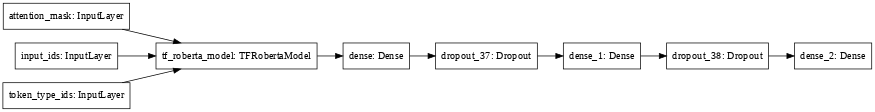

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, rankdir='LR', dpi=52)

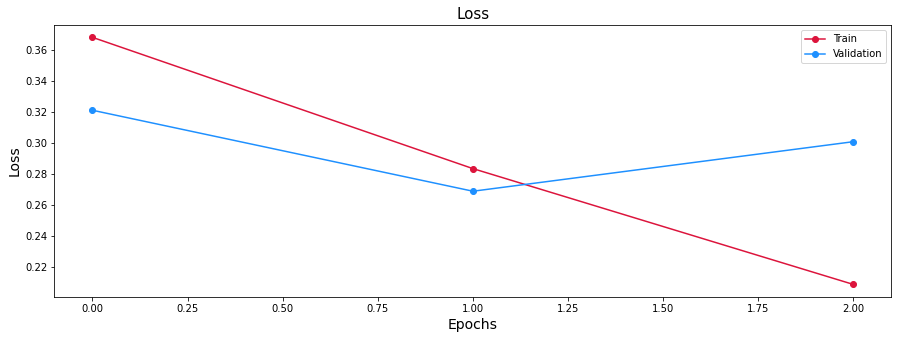

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
    plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
    plt.xlabel('Epochs', fontsize = 14)
    plt.ylabel('Loss',fontsize=14)
    plt.title('Loss', fontsize=15)
    plt.legend(loc='best')
    fig.savefig(f'{MODEL_PATH}/evaluation.png', bbox_inches='tight') 
    plt.show()
plot_history(history)

# Prediction

## Preprocess test data

In [ ]:
df_test = pd.read_csv(path_ViCTSD_test_toxic)
test_dataset = load_dataset('csv', data_files={'test': path_ViCTSD_test_toxic})
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-9bd49dde8350a844/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


In [ ]:
y_test = np.array(df_test['Toxicity'].tolist())
test_tf_dataset = preprocess_tokenized_dataset(
    tokenized_test['test'], 
    tokenizer, 
    y_test, 
    BATCH_SIZE, 
    shuffle = False
)
test_dataset

DatasetDict({
    test: Dataset({
        features: ['id', 'Comment', 'Constructiveness', 'Toxicity', 'Title', 'Topic'],
        num_rows: 1000
    })
})

In [ ]:
y_test.shape

(1000,)

## Predict on test data

In [ ]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    return np.argmax(y_pred, axis=-1) 

In [ ]:
with strategy.scope():
    y_pred = predict(model, test_tf_dataset, BATCH_SIZE, verbose=1)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None, 1) dtype=int64>]


32/32 [==============================] - 16s 386ms/step


In [ ]:
from sklearn import metrics

print("\n Evaluating Model ... \n")
metric = metrics.classification_report(y_test, y_pred, output_dict=True)
print(metrics.classification_report(y_test, y_pred, digits=4))#, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0     0.9334    0.9607    0.9468       890
           1     0.5833    0.4455    0.5052       110

    accuracy                         0.9040      1000
   macro avg     0.7584    0.7031    0.7260      1000
weighted avg     0.8949    0.9040    0.8983      1000



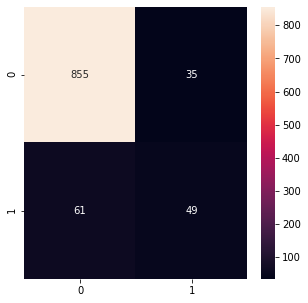

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(y_test, y_pred, metric, name_model)